# XAI PROJECT - CREDIT CARD FRAUD DETECTION
Analiza spójności metod XAI (SHAP, LIME, DALEX)

In [53]:
pip install kaggle

## Importy

In [54]:
import warnings
warnings.filterwarnings('ignore')

import kagglehub
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# XAI Libraries
import shap
import lime
import lime.lime_tabular
import dalex as dx
import importlib.metadata # Import for version checking

# Visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Wszystkie biblioteki załadowane!")
print(f"SHAP version: {shap.__version__}")
print(f"DALEX version: {dx.__version__}")
try:
    lime_version = importlib.metadata.version('lime')
except importlib.metadata.PackageNotFoundError:
    lime_version = "Version not found"
print(f"LIME version: {lime_version}")

✓ Wszystkie biblioteki załadowane!
SHAP version: 0.50.0
DALEX version: 1.7.2
LIME version: 0.2.0.1


## WCZYTANIE DANYCH - CREDIT CARD FRAUD

In [55]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)
csv_file_path = os.path.join(path, 'creditcard.csv')
df = pd.read_csv(csv_file_path)
print("✓ Dane załadowane z KaggleHub")


print(f"\nKształt datasetu: {df.shape}")
print(f"Liczba cech: {df.shape[1] - 1}")  # -1 bo Class to target
print(f"Liczba próbek: {len(df)}")

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud
✓ Dane załadowane z KaggleHub

Kształt datasetu: (284807, 31)
Liczba cech: 30
Liczba próbek: 284807


## EKSPLORACYJNA ANALIZA DANYCH (EDA)


 Informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  

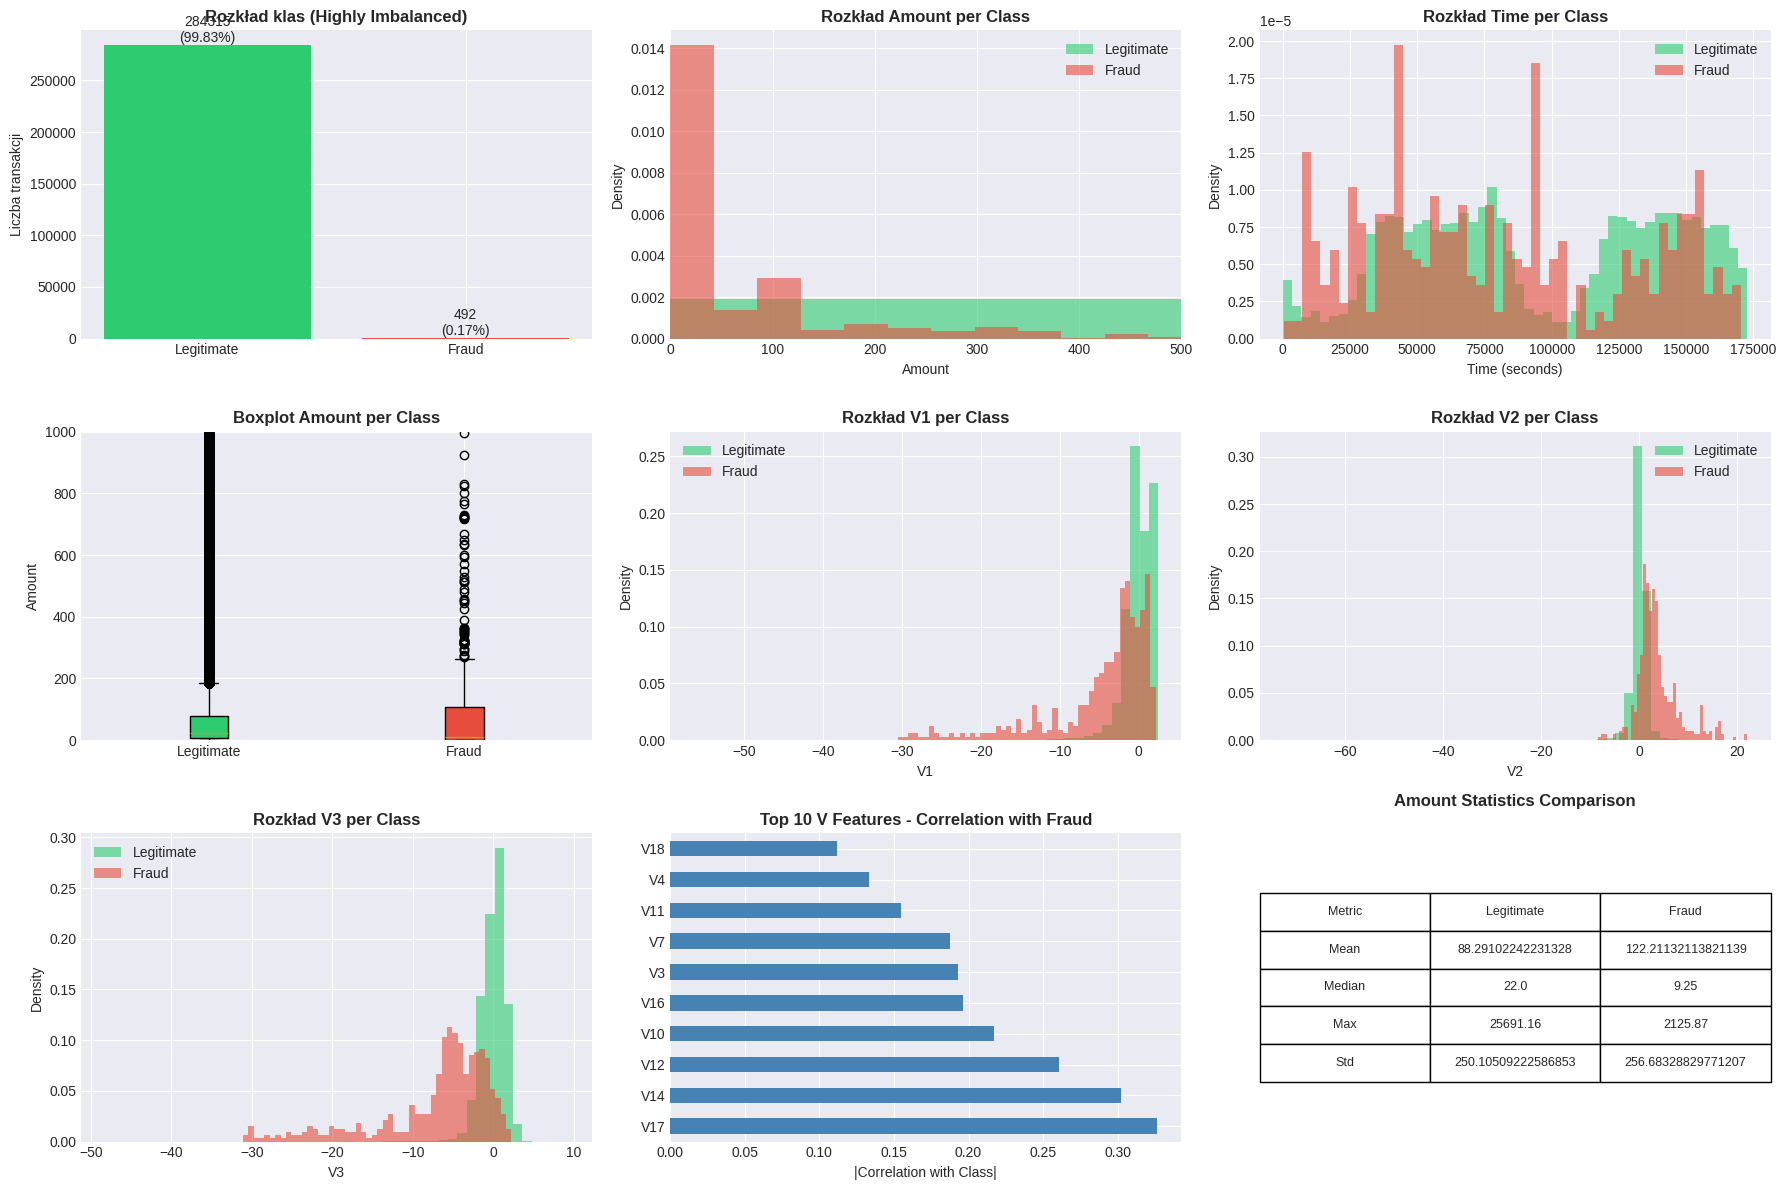

In [56]:
# Podstawowe statystyki
print("\n Informacje o danych:")
print(df.info())

print("\n Pierwsze wiersze:")
print(df.head())

# Rozkład klasy docelowej
print("\n Rozkład klasy docelowej (Class):")
print(df['Class'].value_counts())
fraud_percentage = (df['Class'].sum() / len(df)) * 100
print(f"\nProporcje:")
print(f"Legitimate: {(df['Class']==0).sum()} ({100-fraud_percentage:.2f}%)")
print(f"Fraud: {(df['Class']==1).sum()} ({fraud_percentage:.2f}%)")
print(f"\n Dataset jest niezbalansowany (fraud: {fraud_percentage:.2f}%)")

# Sprawdzenie braków danych
print(f"\n Brakujące wartości: {df.isnull().sum().sum()}")

# Statystyki opisowe
print("\n Statystyki opisowe (wybrane cechy):")
print(df[['Time', 'Amount', 'Class']].describe())

# Wizualizacja EDA
fig = plt.figure(figsize=(18, 12))

# 1. Rozkład klasy
ax1 = plt.subplot(3, 3, 1)
class_counts = df['Class'].value_counts()
bars = ax1.bar(['Legitimate', 'Fraud'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Rozkład klas (Highly Imbalanced)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Liczba transakcji')
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/len(df)*100:.2f}%)',
            ha='center', va='bottom', fontsize=10)

# 2. Rozkład Amount
ax2 = plt.subplot(3, 3, 2)
ax2.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.6, label='Legitimate', color='#2ecc71', density=True)
ax2.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.6, label='Fraud', color='#e74c3c', density=True)
ax2.set_xlabel('Amount')
ax2.set_ylabel('Density')
ax2.set_title('Rozkład Amount per Class', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlim([0, 500])  # Focus na niższe kwoty

# 3. Rozkład Time
ax3 = plt.subplot(3, 3, 3)
ax3.hist(df[df['Class']==0]['Time'], bins=50, alpha=0.6, label='Legitimate', color='#2ecc71', density=True)
ax3.hist(df[df['Class']==1]['Time'], bins=50, alpha=0.6, label='Fraud', color='#e74c3c', density=True)
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Density')
ax3.set_title('Rozkład Time per Class', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Boxplot Amount
ax4 = plt.subplot(3, 3, 4)
data_to_plot = [df[df['Class']==0]['Amount'], df[df['Class']==1]['Amount']]
bp = ax4.boxplot(data_to_plot, labels=['Legitimate', 'Fraud'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
ax4.set_ylabel('Amount')
ax4.set_title('Boxplot Amount per Class', fontsize=12, fontweight='bold')
ax4.set_ylim([0, 1000])

# 5-7. Przykładowe cechy V1, V2, V3
for idx, v_col in enumerate(['V1', 'V2', 'V3'], start=5):
    ax = plt.subplot(3, 3, idx)
    ax.hist(df[df['Class']==0][v_col], bins=50, alpha=0.6, label='Legitimate', color='#2ecc71', density=True)
    ax.hist(df[df['Class']==1][v_col], bins=50, alpha=0.6, label='Fraud', color='#e74c3c', density=True)
    ax.set_xlabel(v_col)
    ax.set_ylabel('Density')
    ax.set_title(f'Rozkład {v_col} per Class', fontsize=12, fontweight='bold')
    ax.legend()

# 8. Korelacja z Class (top 10 V features)
ax8 = plt.subplot(3, 3, 8)
v_columns = [col for col in df.columns if col.startswith('V')]
correlations = df[v_columns + ['Class']].corr()['Class'].drop('Class').abs().sort_values(ascending=False)[:10]
correlations.plot(kind='barh', ax=ax8, color='steelblue')
ax8.set_xlabel('|Correlation with Class|')
ax8.set_title('Top 10 V Features - Correlation with Fraud', fontsize=12, fontweight='bold')

# 9. Amount statistics
ax9 = plt.subplot(3, 3, 9)
stats_data = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Max', 'Std'],
    'Legitimate': [
        df[df['Class']==0]['Amount'].mean(),
        df[df['Class']==0]['Amount'].median(),
        df[df['Class']==0]['Amount'].max(),
        df[df['Class']==0]['Amount'].std()
    ],
    'Fraud': [
        df[df['Class']==1]['Amount'].mean(),
        df[df['Class']==1]['Amount'].median(),
        df[df['Class']==1]['Amount'].max(),
        df[df['Class']==1]['Amount'].std()
    ]
})
ax9.axis('tight')
ax9.axis('off')
table = ax9.table(cellText=stats_data.values, colLabels=stats_data.columns,
                  cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
ax9.set_title('Amount Statistics Comparison', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## PREPROCESSING I PODZIAŁ DANYCH

In [57]:
# Przygotowanie X i y
X = df.drop('Class', axis=1)
y = df['Class']

print(f"\n Original data shape:")
print(f"  X: {X.shape}")
print(f"  y distribution: {dict(y.value_counts())}")

# Podział na train/test (stratified z uwagi na niezbalansowanie)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n Podział danych:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")
print(f"  Rozkład y_train: {dict(y_train.value_counts())}")
print(f"  Rozkład y_test: {dict(y_test.value_counts())}")

# Normalizacja Amount i Time (V features już są znormalizowane przez PCA)
# Amount i Time są w oryginalnej skali
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Skalowanie tylko Amount i Time
X_train_scaled[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])
X_test_scaled[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])

# SMOTE + Undersampling
print(f"  Przed: {dict(y_train.value_counts())}")

smote = SMOTE(sampling_strategy=0.3, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
X_train_balanced, y_train_balanced = under.fit_resample(X_train_balanced, y_train_balanced)

print(f" Po SMOTE+Undersampling: {dict(pd.Series(y_train_balanced).value_counts())}")
print(f" Dataset treningowy zbalansowany 1:{(y_train_balanced==0).sum()/(y_train_balanced==1).sum():.1f})")

# Konwersja z powrotem na DataFrame
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train_scaled.columns)


 Original data shape:
  X: (284807, 30)
  y distribution: {0: np.int64(284315), 1: np.int64(492)}

 Podział danych:
  Training set: (227845, 30)
  Test set: (56962, 30)
  Rozkład y_train: {0: np.int64(227451), 1: np.int64(394)}
  Rozkład y_test: {0: np.int64(56864), 1: np.int64(98)}
  Przed: {0: np.int64(227451), 1: np.int64(394)}
 Po SMOTE+Undersampling: {0: np.int64(136470), 1: np.int64(68235)}
 Dataset treningowy zbalansowany 1:2.0)


## TRENING MODELI


 Training Random Forest...
 Random Forest trained

 Random Forest Performance:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.71      0.86      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9834
F1-Score (Fraud): 0.7778

 Training XGBoost...
 XGBoost trained

 XGBoost Performance:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.61      0.88      0.72        98

    accuracy                           1.00     56962
   macro avg       0.80      0.94      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9717
F1-Score (Fraud): 0.7167


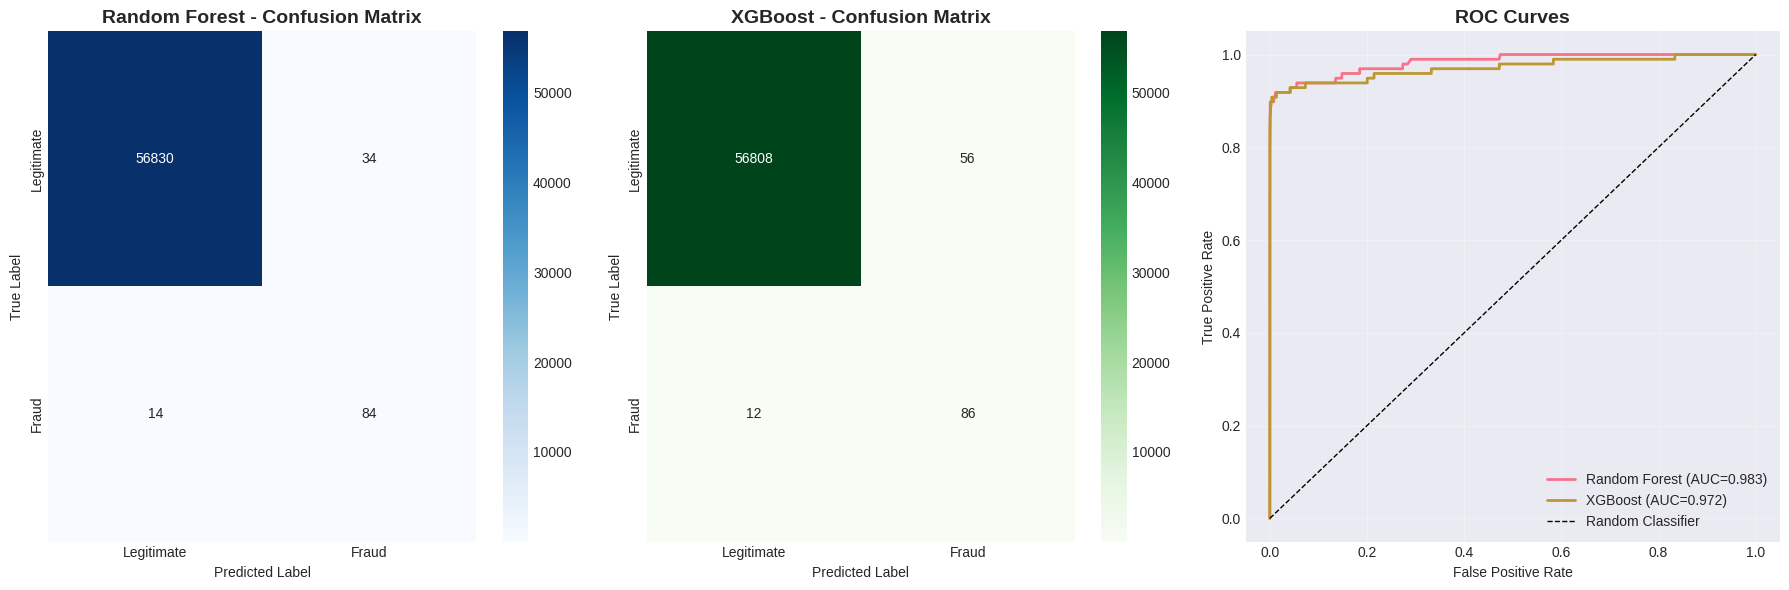

\ Model performance plot saved

✅ Model wybrany do analizy XAI: Random Forest


In [58]:
# Model 1: Random Forest
print("\n Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',  # Dodatkowa waga dla fraud
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(" Random Forest trained")
print("\n Random Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"F1-Score (Fraud): {f1_score(y_test, y_pred_rf):.4f}")

# Model 2: XGBoost
print("\n Training XGBoost...")

# Oblicz scale_pos_weight dla XGBoost
scale_pos_weight = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_model.fit(X_train_balanced, y_train_balanced)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print(" XGBoost trained")
print("\n XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"F1-Score (Fraud): {f1_score(y_test, y_pred_xgb):.4f}")

# Confusion Matrix i ROC Curve
fig = plt.figure(figsize=(18, 6))

# CM - Random Forest
ax1 = plt.subplot(1, 3, 1)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['Legitimate', 'Fraud'])
ax1.set_yticklabels(['Legitimate', 'Fraud'])

# CM - XGBoost
ax2 = plt.subplot(1, 3, 2)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=ax2)
ax2.set_title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(['Legitimate', 'Fraud'])
ax2.set_yticklabels(['Legitimate', 'Fraud'])

# ROC Curves
ax3 = plt.subplot(1, 3, 3)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

ax3.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_proba_rf):.3f})', linewidth=2)
ax3.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_proba_xgb):.3f})', linewidth=2)
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
bbox_inches='tight'
plt.show()

print("\ Model performance plot saved")

# Wybór głównego modelu do XAI
model = rf_model
print(f"\n✅ Model wybrany do analizy XAI: Random Forest")

## XAI - METODY GLOBALNE

### SHAP - Global Summary

✓ SHAP values computed


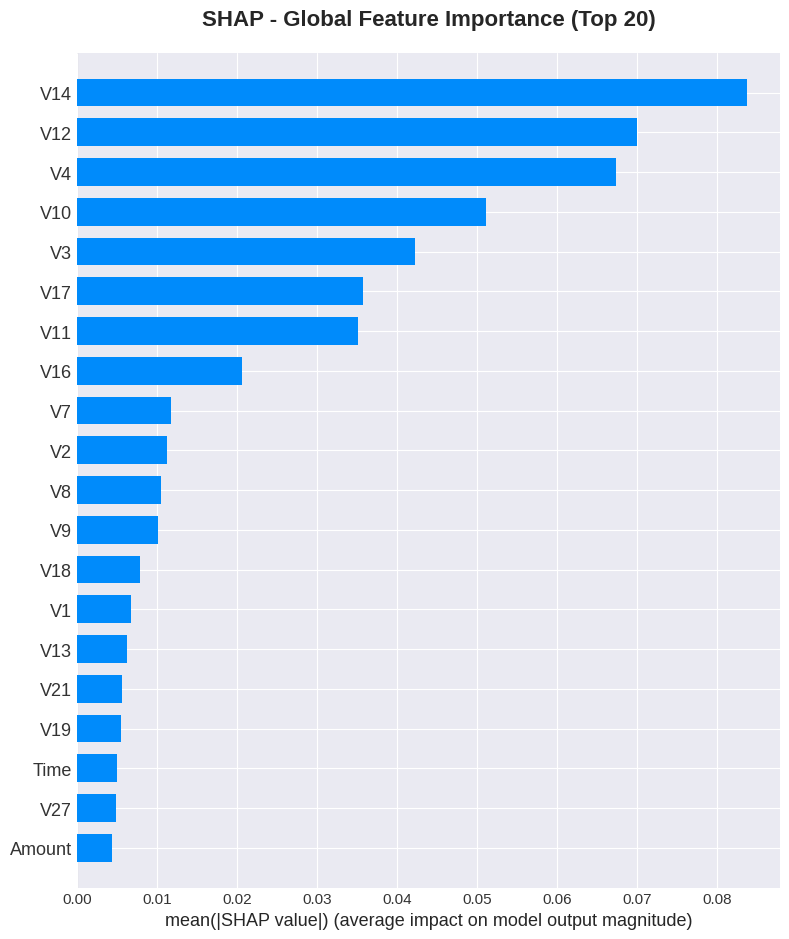

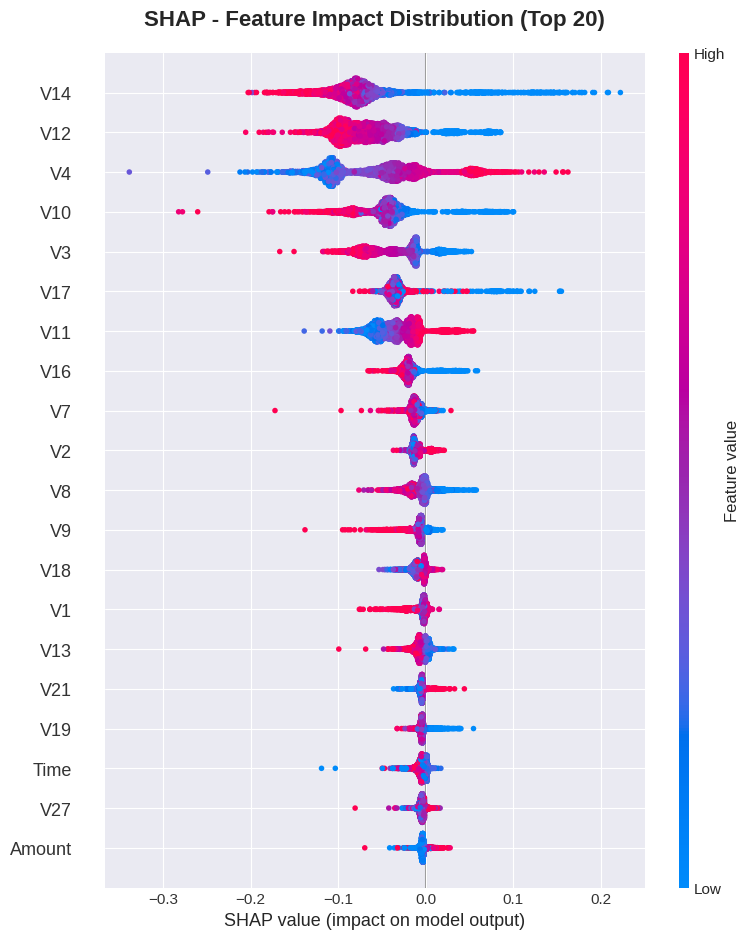


 Top 15 Features (SHAP):
feature  importance
    V14    0.083645
    V12    0.069909
     V4    0.067287
    V10    0.051047
     V3    0.042201
    V17    0.035678
    V11    0.035052
    V16    0.020622
     V7    0.011747
     V2    0.011272
     V8    0.010475
     V9    0.010084
    V18    0.007930
     V1    0.006769
    V13    0.006223


In [62]:
# TreeExplainer dla tree-based models
explainer_shap = shap.TreeExplainer(model)

# Użyto podzbioru testowego (SHAP możze być wolny dla dużych danych)
# Modifikacja próbkowania, aby zapewnić obecność obu klas w próbce
sample_size = 5000 # Maksymalny rozmiar próbki dla XAI

# Wybieramy wszystkie transakcje oszukańcze z zestawu testowego
fraud_indices = y_test[y_test == 1].index
X_test_sample_fraud = X_test_scaled.loc[fraud_indices]
y_test_sample_fraud = y_test.loc[fraud_indices]

# Określamy, ile legalnych transakcji jest potrzebnych do uzupełnienia próbki
num_legit_needed = sample_size - len(fraud_indices)

# Zapewniamy, że nie próbujemy pobrać więcej legalnych transakcji niż jest dostępnych
legitimate_indices = y_test[y_test == 0].index
num_legit_to_sample = min(num_legit_needed, len(legitimate_indices))

# Próbkujemy legalne transakcje
X_test_sample_legit = X_test_scaled.loc[legitimate_indices].sample(n=num_legit_to_sample, random_state=42)
y_test_sample_legit = y_test.loc[legitimate_indices].sample(n=num_legit_to_sample, random_state=42)

# Łączymy transakcje oszukańcze i próbkowane legalne
X_test_sample = pd.concat([X_test_sample_fraud, X_test_sample_legit])
y_test_sample = pd.concat([y_test_sample_fraud, y_test_sample_legit])

# Mieszamy próbkę
X_test_sample = X_test_sample.sample(frac=1, random_state=42)
y_test_sample = y_test_sample.loc[X_test_sample.index] # Zapewniamy zgodność y z przetasowanym X

shap_values = explainer_shap.shap_values(X_test_sample)

if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_class1 = shap_values[:, :, 1]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    shap_values_class1 = shap_values
else:
    raise TypeError(f"Unexpected SHAP values type: {type(shap_values)}, ndim={getattr(shap_values, 'ndim', 'N/A')}")

print("✓ SHAP values computed")

# SHAP Summary Plot - Bar
plt.figure(figsize=(12, 10))

shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False, max_display=20)
plt.title('SHAP - Global Feature Importance (Top 20)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_global_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Beeswarm Plot
plt.figure(figsize=(12, 10))

shap.summary_plot(shap_values_class1, X_test_sample, show=False, max_display=20)
plt.title('SHAP - Feature Impact Distribution (Top 20)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top features według SHAP
shap_importance = np.abs(shap_values_class1).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance': shap_importance
}).sort_values('importance', ascending=False)

print("\n Top 15 Features (SHAP):")
print(shap_importance_df.head(15).to_string(index=False))

### 6.2 DALEX - Model Profile

Preparation of a new explainer is initiated

  -> data              : 5000 rows 30 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5000 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest
  -> predict function  : <function yhat_proba_default at 0x7bb4f8de7920> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.0252, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.826, mean = -0.00558, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
  Computing permutation importance

 Top 15 Features (DALEX Permutation Importance):
variable  dropout_loss         label
      V8      0.036548 Random Forest
      V7

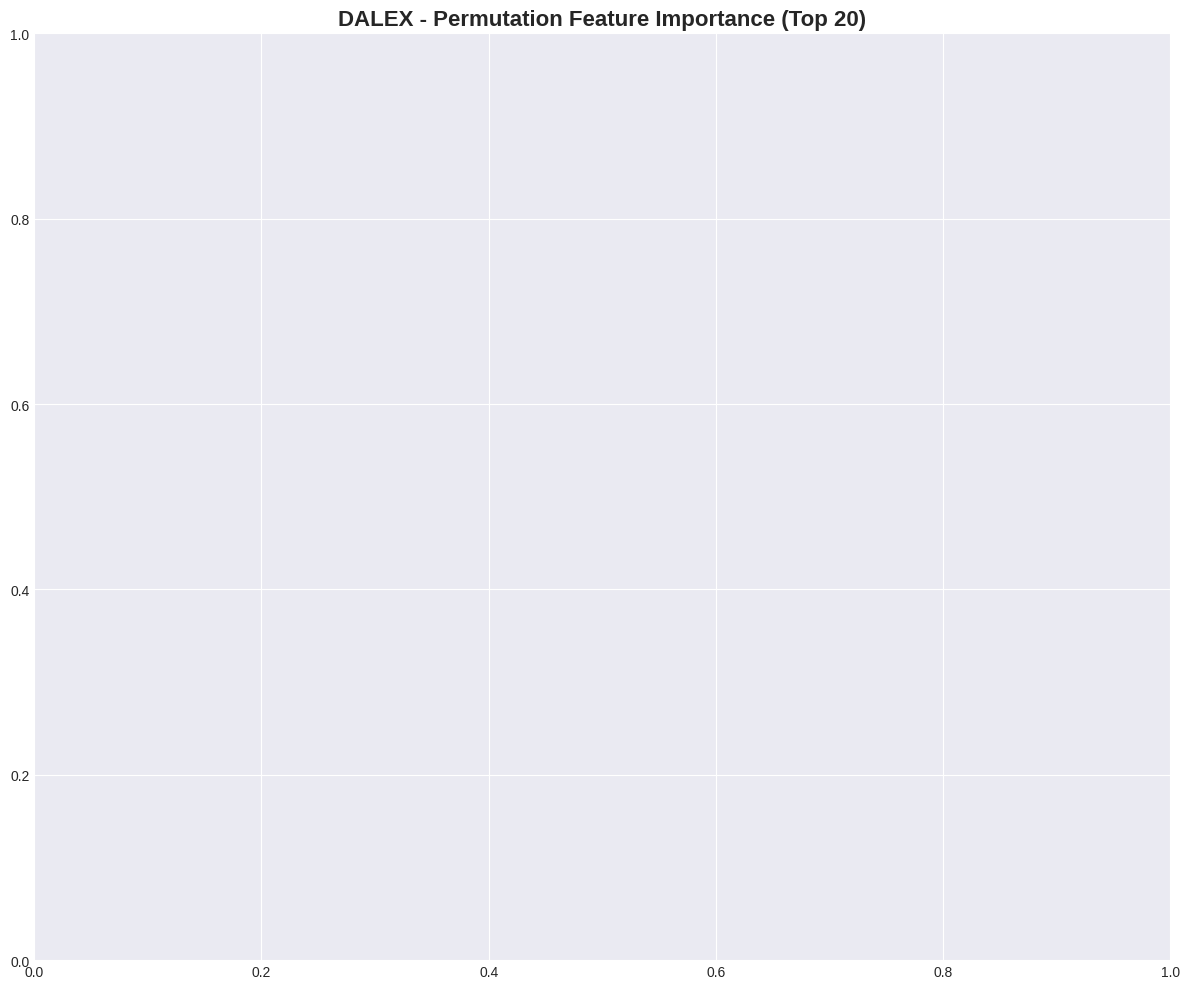

  Computing PDP for: ['V8', 'V7']


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


<Figure size 640x480 with 0 Axes>

In [63]:
# Użyto ten sam sample dla spójności
exp_dalex = dx.Explainer(
    model,
    X_test_sample,
    y_test_sample,
    label="Random Forest"
)

# Variable Importance (Permutation)
print("  Computing permutation importance")
vi_dalex = exp_dalex.model_parts()
print("\n Top 15 Features (DALEX Permutation Importance):")
vi_result = vi_dalex.result[vi_dalex.result['variable'] != '_baseline_'].copy()
vi_result = vi_result[vi_result.variable != '_full_model_']
vi_result = vi_result.sort_values('dropout_loss', ascending=False)
print(vi_result.head(15).to_string(index=False))

# Plot DALEX Variable Importance
plt.figure(figsize=(12, 10))
vi_dalex.plot(max_vars=20)
plt.title('DALEX - Permutation Feature Importance (Top 20)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Partial Dependence Profile (dla top 4 cech)
top_features_dalex = vi_result.head(4)['variable'].tolist()

if len(top_features_dalex) >= 2:
    print(f"  Computing PDP for: {top_features_dalex[:2]}")
    pdp_dalex = exp_dalex.model_profile(variables=top_features_dalex[:2])
    pdp_dalex.plot()
    plt.suptitle('DALEX - Partial Dependence Plots (Top 2 Features)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### Native Feature Importance (Random Forest)


┡ Top 15 Features (RF Native):
feature  importance
    V14    0.194080
    V10    0.112474
     V4    0.099457
    V12    0.097945
    V17    0.088279
     V3    0.056815
    V11    0.055689
    V16    0.049291
     V2    0.037865
     V9    0.026502
    V21    0.016321
     V8    0.016096
     V7    0.015468
    V18    0.012768
    V27    0.012028


<Figure size 1200x1000 with 0 Axes>

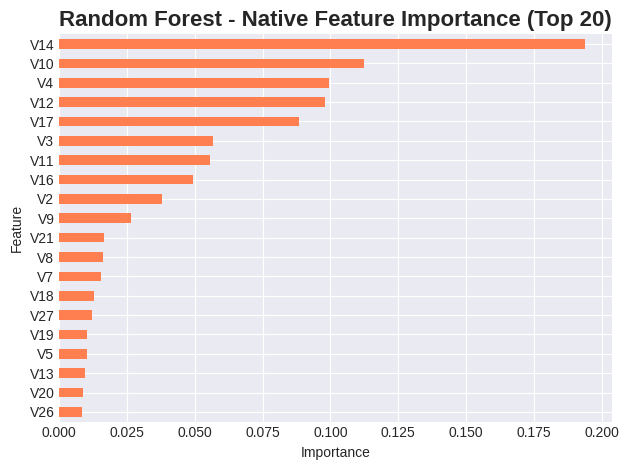

In [64]:
rf_importance = pd.DataFrame({
    'feature': X_train_balanced.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n┡ Top 15 Features (RF Native):")
print(rf_importance.head(15).to_string(index=False))

plt.figure(figsize=(12, 10))
rf_importance.head(20).plot(x='feature', y='importance', kind='barh', color='coral', legend=False)
plt.title('Random Forest - Native Feature Importance (Top 20)', fontsize=16, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_native_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## XAI - METODY LOKALNE

In [65]:
# Prawdziwy fraud - wysoka kwota
true_fraud_high = X_test_scaled[(y_test == 1) & (y_pred_rf == 1)].copy()
true_fraud_high['Amount_original'] = X_test.loc[true_fraud_high.index, 'Amount']
fraud_high_idx = true_fraud_high.nlargest(1, 'Amount_original').index[0]

# Prawdziwy fraud - niska kwota
fraud_low_idx = true_fraud_high.nsmallest(1, 'Amount_original').index[0]

# Prawdziwy legitimate
true_legit_idx = X_test_scaled[(y_test == 0) & (y_pred_rf == 0)].index[0]

# Błędna klasyfikacja
false_positive_candidates = X_test_scaled[(y_test == 0) & (y_pred_rf == 1)].index
if len(false_positive_candidates) > 0:
    misclassified_idx = false_positive_candidates[0]
    misclass_type = "False_Positive"
else:
    false_negative_candidates = X_test_scaled[(y_test == 1) & (y_pred_rf == 0)].index
    if len(false_negative_candidates) > 0:
        misclassified_idx = false_negative_candidates[0]
        misclass_type = "False_Negative"
    else:
        misclassified_idx = fraud_high_idx
        misclass_type = "No_misclassification"

instances_to_explain = {
    'Fraud_High_Amount': fraud_high_idx,
    'Fraud_Low_Amount': fraud_low_idx,
    'True_Legitimate': true_legit_idx,
    f'Misclassified_{misclass_type}': misclassified_idx
}

print(f"\n┡ Wybrane instancje do wyjaśnienia:")
for name, idx in instances_to_explain.items():
    pred = model.predict(X_test_scaled.loc[[idx]])[0]
    true = y_test.loc[idx]
    prob = model.predict_proba(X_test_scaled.loc[[idx]])[0]
    amount_orig = X_test.loc[idx, 'Amount']
    print(f"  {name}:")
    print(f"    Index: {idx}")
    print(f"    True: {'Fraud' if true==1 else 'Legit'}, Pred: {'Fraud' if pred==1 else 'Legit'}")
    print(f"    Proba: [Legit: {prob[0]:.3f}, Fraud: {prob[1]:.3f}]")
    print(f"    Amount: ${amount_orig:.2f}")


┡ Wybrane instancje do wyjaśnienia:
  Fraud_High_Amount:
    Index: 6971
    True: Fraud, Pred: Fraud
    Proba: [Legit: 0.419, Fraud: 0.581]
    Amount: $1809.68
  Fraud_Low_Amount:
    Index: 141257
    True: Fraud, Pred: Fraud
    Proba: [Legit: 0.000, Fraud: 1.000]
    Amount: $0.00
  True_Legitimate:
    Index: 263020
    True: Legit, Pred: Legit
    Proba: [Legit: 1.000, Fraud: 0.000]
    Amount: $23.00
  Misclassified_False_Positive:
    Index: 190263
    True: Legit, Pred: Fraud
    Proba: [Legit: 0.056, Fraud: 0.944]
    Amount: $0.76


### SHAP - Local Explanations

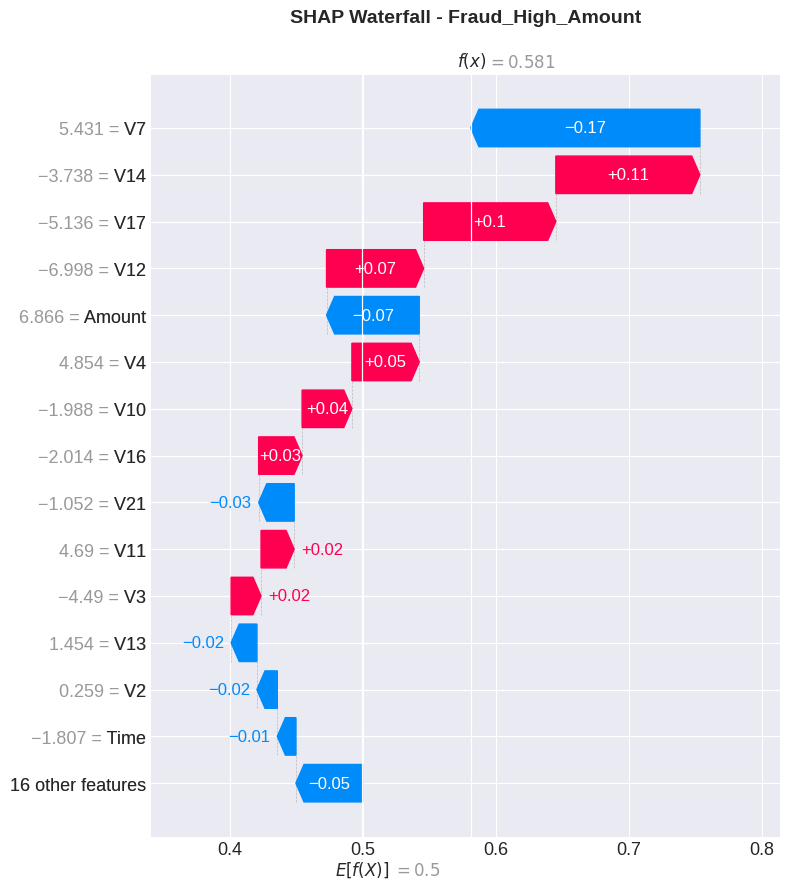

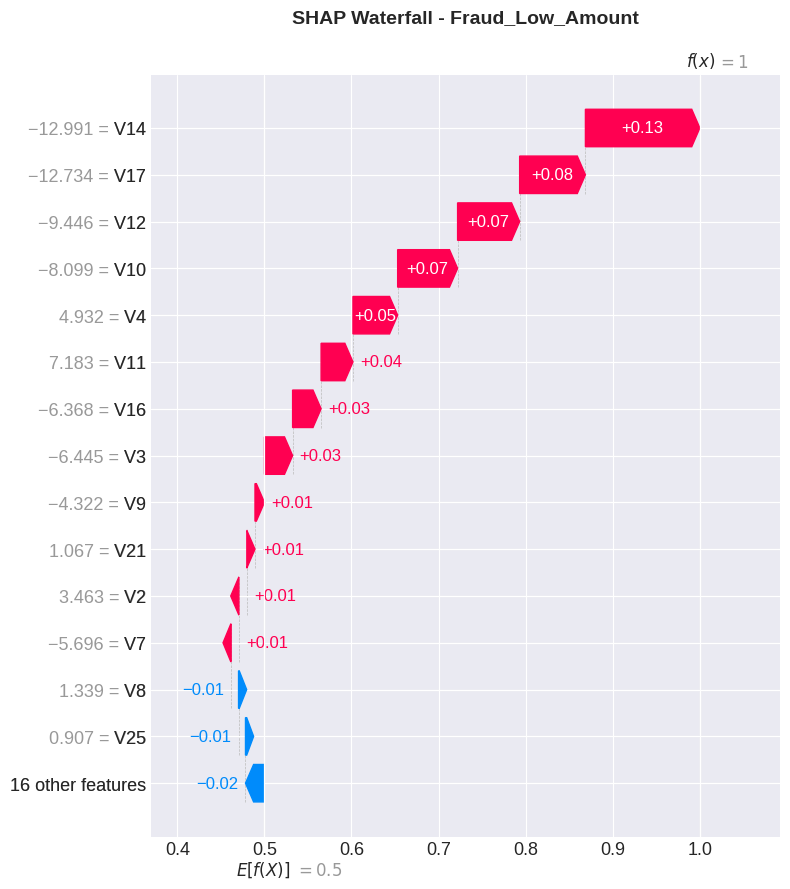

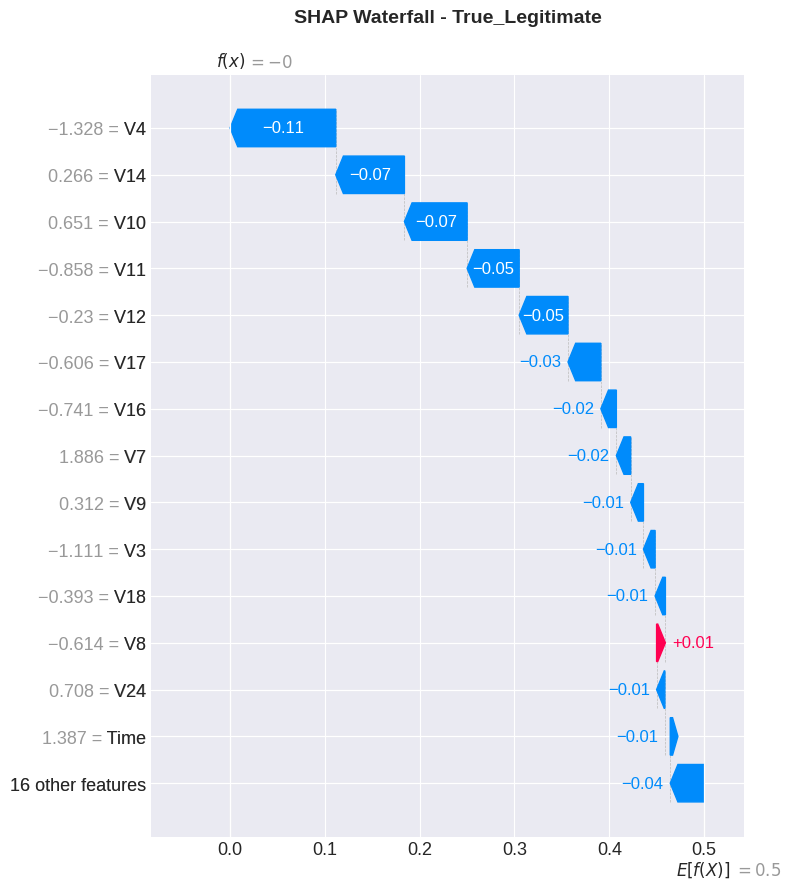

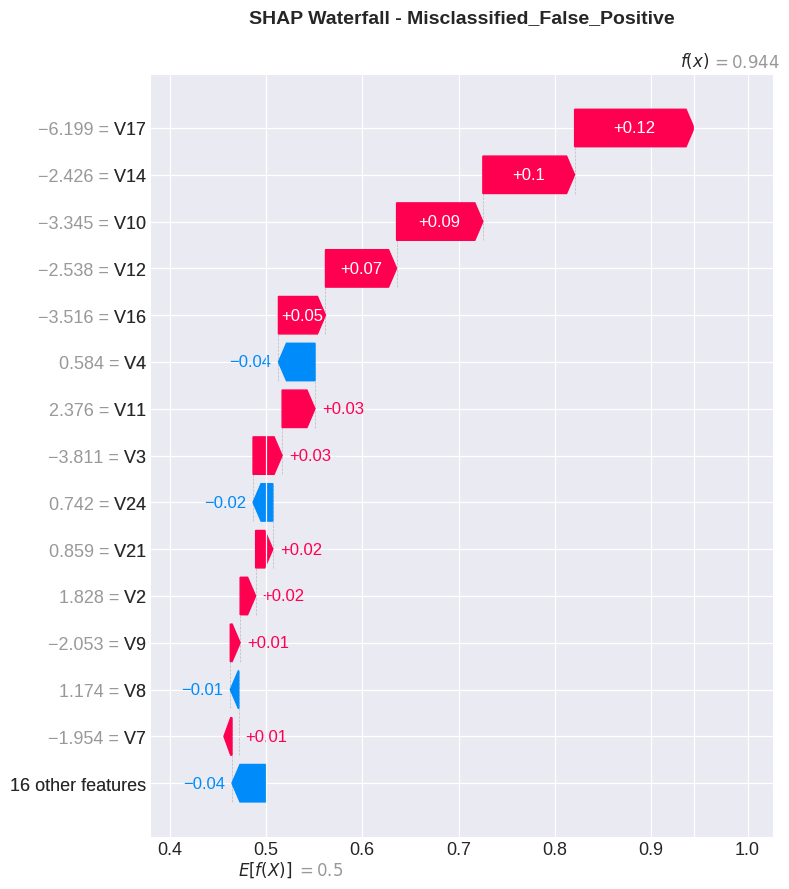

In [66]:
# Oblicz SHAP values dla wybranych instancji
instances_df = X_test_scaled.loc[list(instances_to_explain.values())]
shap_values_local = explainer_shap.shap_values(instances_df)

# Determine the SHAP values for the positive class (class 1) for local explanations
shap_values_class1_local = None
if isinstance(shap_values_local, list):
    shap_values_class1_local = shap_values_local[1]
elif isinstance(shap_values_local, np.ndarray) and shap_values_local.ndim == 3:
    shap_values_class1_local = shap_values_local[:, :, 1]
elif isinstance(shap_values_local, np.ndarray) and shap_values_local.ndim == 2:
    shap_values_class1_local = shap_values_local
else:
    raise TypeError(f"Unexpected type or dimension for local SHAP values: {type(shap_values_local)}, ndim={getattr(shap_values_local, 'ndim', 'N/A')}")

for i, (name, idx) in enumerate(instances_to_explain.items()):
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_class1_local[i],
            base_values=explainer_shap.expected_value[1] if isinstance(explainer_shap.expected_value, (list, np.ndarray)) else explainer_shap.expected_value,
            data=instances_df.iloc[i],
            feature_names=instances_df.columns.tolist()
        ),
        max_display=15,
        show=False
    )
    plt.title(f'SHAP Waterfall - {name}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

### LIME - Local Explanations

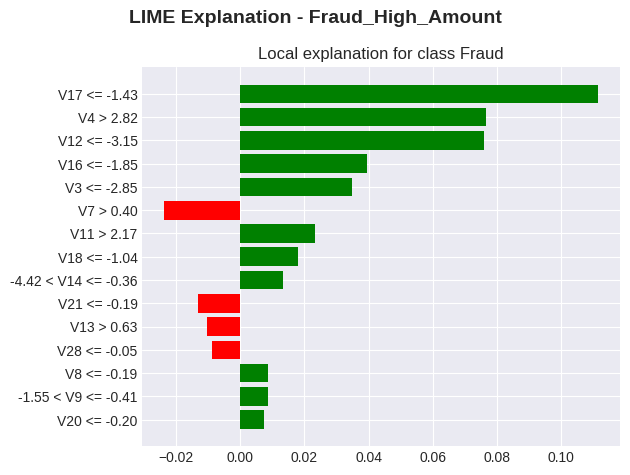


 Fraud_High_Amount:
 Prediction proba: [0.41872478 0.58127522]
 Top 5 features: ['V17 <= -1.43', 'V4 > 2.82', 'V12 <= -3.15', 'V16 <= -1.85', 'V3 <= -2.85']


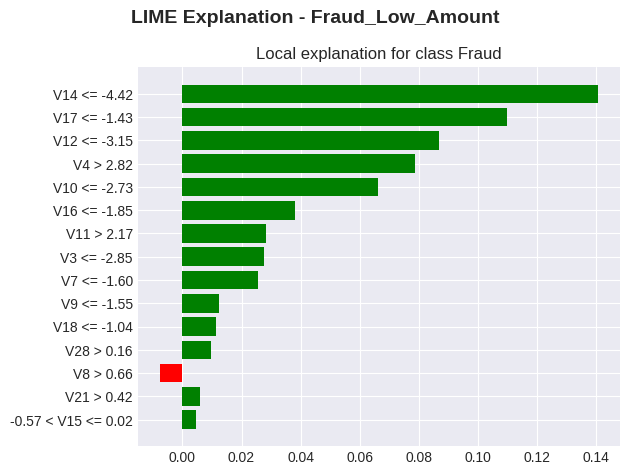


 Fraud_Low_Amount:
 Prediction proba: [3.58888469e-05 9.99964111e-01]
 Top 5 features: ['V14 <= -4.42', 'V17 <= -1.43', 'V12 <= -3.15', 'V4 > 2.82', 'V10 <= -2.73']


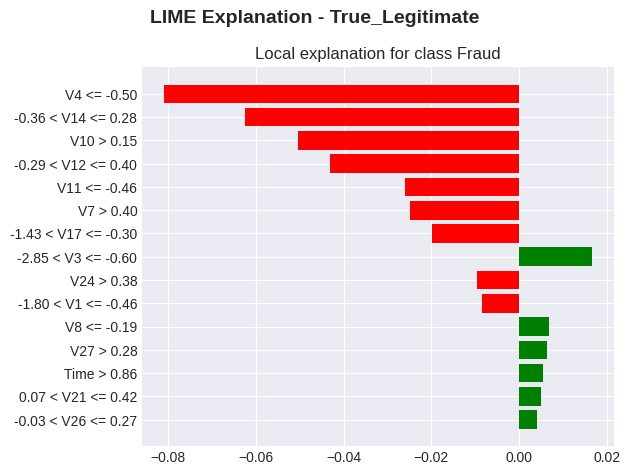


 True_Legitimate:
 Prediction proba: [1. 0.]
 Top 5 features: ['V4 <= -0.50', '-0.36 < V14 <= 0.28', 'V10 > 0.15', '-0.29 < V12 <= 0.40', 'V11 <= -0.46']


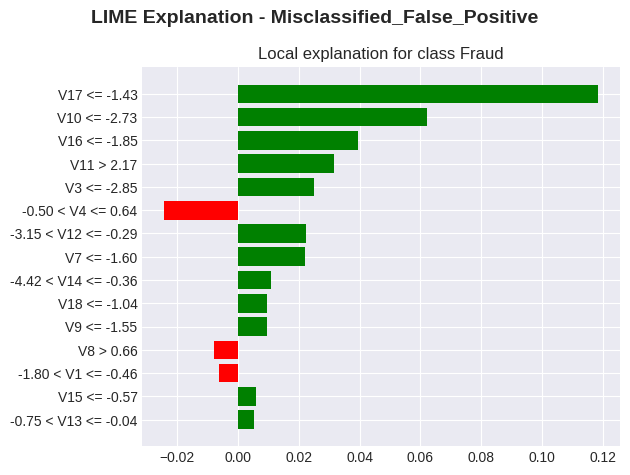


 Misclassified_False_Positive:
 Prediction proba: [0.05557363 0.94442637]
 Top 5 features: ['V17 <= -1.43', 'V10 <= -2.73', 'V16 <= -1.85', 'V11 > 2.17', 'V3 <= -2.85']


In [67]:
# Stwórz LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_balanced.values,
    feature_names=X_train_balanced.columns.tolist(),
    class_names=['Legitimate', 'Fraud'],
    mode='classification',
    random_state=42
)

lime_explanations = {}
for name, idx in instances_to_explain.items():
    instance = X_test_scaled.loc[idx].values

    exp_lime = explainer_lime.explain_instance(
        instance,
        model.predict_proba,
        num_features=15
    )

    lime_explanations[name] = exp_lime

    fig = exp_lime.as_pyplot_figure()
    fig.suptitle(f'LIME Explanation - {name}', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    print(f"\n {name}:")
    print(f" Prediction proba: {exp_lime.predict_proba}")
    print(f" Top 5 features: {[f[0] for f in exp_lime.as_list()[:5]]}")

### ANALIZA SPÓJNOŚĆ METOD XAI

### Porównanie Global Feature Importance

 Rank SHAP DALEX RF Native
    1  V14    V8       V14
    2  V12    V7       V10
    3   V4   V14        V4
    4  V10    V4       V12
    5   V3    V2       V17
    6  V17   V13        V3
    7  V11   V28       V11
    8  V16    V6       V16
    9   V7   V22        V2
   10   V2   V26        V9
   11   V8    V1       V21
   12   V9  Time        V8
   13  V18    V3        V7
   14   V1    V5       V18
   15  V13   V27       V27

 Common features in top 15 across all methods: 6
 {'V2', 'V8', 'V4', 'V7', 'V3', 'V14'}

 Jaccard Similarity (top 15 features):
 SHAP vs DALEX: 0.364
 SHAP vs RF Native: 0.765
 DALEX vs RF Native: 0.304


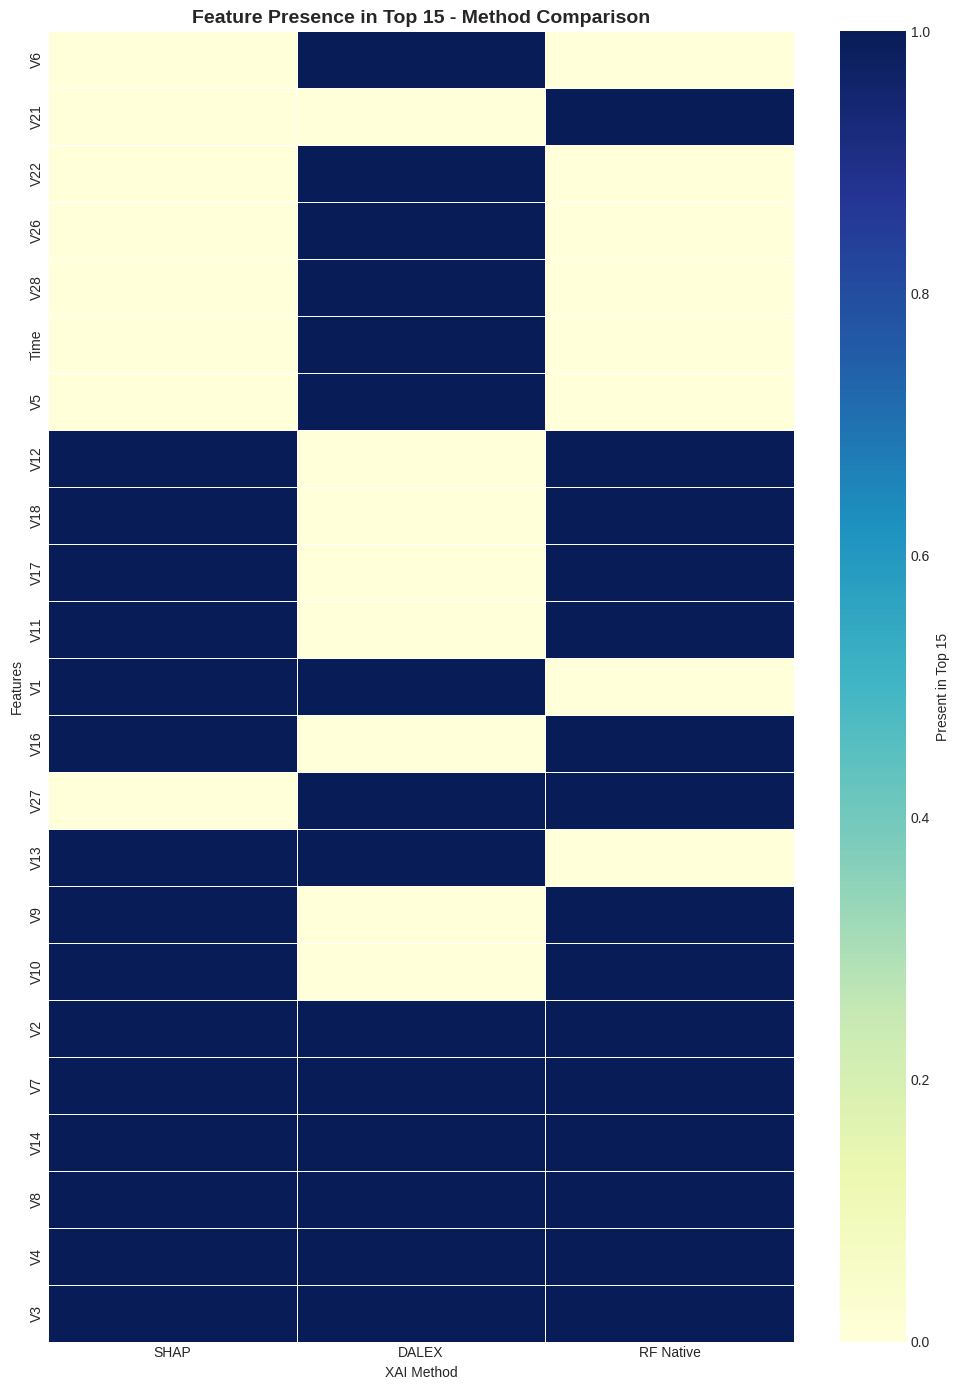

In [68]:
# Zbierz top 15 z każdej metody
shap_top15 = shap_importance_df.head(15)['feature'].tolist()
dalex_top15 = vi_result.head(15)['variable'].tolist()
rf_top15 = rf_importance.head(15)['feature'].tolist()

# DataFrame porównawczy
comparison_df = pd.DataFrame({
    'Rank': range(1, 16),
    'SHAP': shap_top15,
    'DALEX': dalex_top15,
    'RF Native': rf_top15
})

print(comparison_df.to_string(index=False))

# Wspólne cechy
common_top15 = set(shap_top15) & set(dalex_top15) & set(rf_top15)
print(f"\n Common features in top 15 across all methods: {len(common_top15)}")
print(f" {common_top15}")

# Jaccard similarity
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

print(f"\n Jaccard Similarity (top 15 features):")
jacc_shap_dalex = jaccard_similarity(shap_top15, dalex_top15)
jacc_shap_rf = jaccard_similarity(shap_top15, rf_top15)
jacc_dalex_rf = jaccard_similarity(dalex_top15, rf_top15)
print(f" SHAP vs DALEX: {jacc_shap_dalex:.3f}")
print(f" SHAP vs RF Native: {jacc_shap_rf:.3f}")
print(f" DALEX vs RF Native: {jacc_dalex_rf:.3f}")

# Heatmap
all_features = set().union(set(shap_top15), set(dalex_top15), set(rf_top15))
feature_presence = pd.DataFrame({
    'Feature': list(all_features),
    'SHAP': [f in set(shap_top15) for f in all_features],
    'DALEX': [f in set(dalex_top15) for f in all_features],
    'RF Native': [f in set(rf_top15) for f in all_features]
})
feature_presence['Count'] = feature_presence[['SHAP', 'DALEX', 'RF Native']].sum(axis=1)
feature_presence = feature_presence.sort_values('Count', ascending=True)

plt.figure(figsize=(10, 14))
sns.heatmap(
    feature_presence[['SHAP', 'DALEX', 'RF Native']].astype(int),
    yticklabels=feature_presence['Feature'],
    cmap='YlGnBu',
    cbar_kws={'label': 'Present in Top 15'},
    linewidths=0.5
)
plt.title('Feature Presence in Top 15 - Method Comparison', fontsize=14, fontweight='bold')
plt.xlabel('XAI Method')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### 8.2 Spearman Rank Correlation

SHAP vs DALEX:     ρ = 0.064, p = 7.3748e-01
SHAP vs RF Native: ρ = 0.943, p = 5.8559e-15
DALEX vs RF Native: ρ = 0.013, p = 9.4697e-01


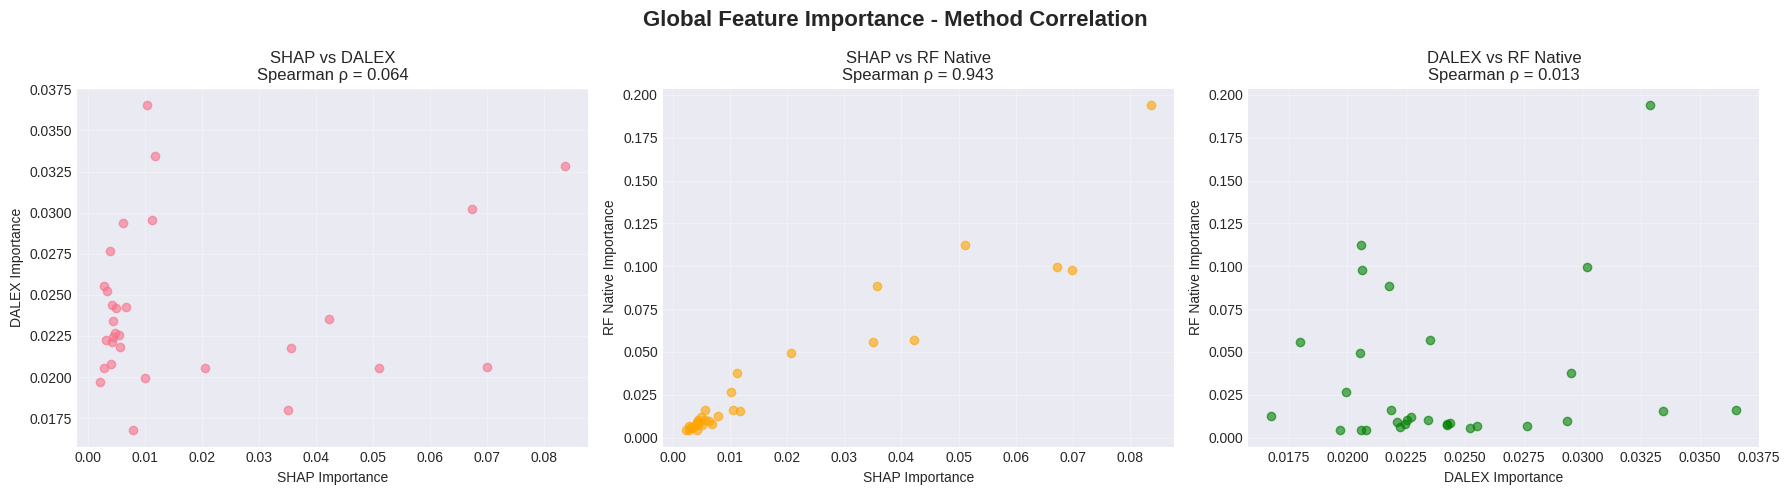

In [69]:
all_features_list = X_train_balanced.columns.tolist()

shap_scores = dict(zip(shap_importance_df['feature'], shap_importance_df['importance']))
dalex_scores = dict(zip(vi_result['variable'], vi_result['dropout_loss']))
rf_scores = dict(zip(rf_importance['feature'], rf_importance['importance']))

importance_comparison = pd.DataFrame({
    'feature': all_features_list,
    'SHAP': [shap_scores.get(f, 0) for f in all_features_list],
    'DALEX': [dalex_scores.get(f, 0) for f in all_features_list],
    'RF_Native': [rf_scores.get(f, 0) for f in all_features_list]
})

from scipy.stats import spearmanr

spearman_shap_dalex = spearmanr(importance_comparison['SHAP'], importance_comparison['DALEX'])
spearman_shap_rf = spearmanr(importance_comparison['SHAP'], importance_comparison['RF_Native'])
spearman_dalex_rf = spearmanr(importance_comparison['DALEX'], importance_comparison['RF_Native'])

print(f"SHAP vs DALEX:     ρ = {spearman_shap_dalex.correlation:.3f}, p = {spearman_shap_dalex.pvalue:.4e}")
print(f"SHAP vs RF Native: ρ = {spearman_shap_rf.correlation:.3f}, p = {spearman_shap_rf.pvalue:.4e}")
print(f"DALEX vs RF Native: ρ = {spearman_dalex_rf.correlation:.3f}, p = {spearman_dalex_rf.pvalue:.4e}")

# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(importance_comparison['SHAP'], importance_comparison['DALEX'], alpha=0.6)
axes[0].set_xlabel('SHAP Importance')
axes[0].set_ylabel('DALEX Importance')
axes[0].set_title(f'SHAP vs DALEX\nSpearman ρ = {spearman_shap_dalex.correlation:.3f}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(importance_comparison['SHAP'], importance_comparison['RF_Native'], alpha=0.6, color='orange')
axes[1].set_xlabel('SHAP Importance')
axes[1].set_ylabel('RF Native Importance')
axes[1].set_title(f'SHAP vs RF Native\nSpearman ρ = {spearman_shap_rf.correlation:.3f}')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(importance_comparison['DALEX'], importance_comparison['RF_Native'], alpha=0.6, color='green')
axes[2].set_xlabel('DALEX Importance')
axes[2].set_ylabel('RF Native Importance')
axes[2].set_title(f'DALEX vs RF Native\nSpearman ρ = {spearman_dalex_rf.correlation:.3f}')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Global Feature Importance - Method Correlation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('consistency_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

### Analiza Spójność Lokalnych Wyjaśnień

In [70]:
#Comparing SHAP vs LIME for local explanations

#Funkcja ekstrakcji nazw cech z LIME
def extract_feature_name(lime_feature_str):
    """Wyciąga nazwę cechy z LIME string ('V17 <= -1.43' -> 'V17')"""
    return lime_feature_str.split()[0]

for i, (name, idx) in enumerate(instances_to_explain.items()):
    print(f"\n{'='*70}")
    print(f"Instance: {name}")
    print(f"{'='*70}")

    # SHAP top features
    shap_local_values = shap_values_class1_local[i]
    shap_local_importance = pd.DataFrame({
        'feature': instances_df.columns,
        'shap_value': shap_local_values,
        'abs_shap': np.abs(shap_local_values)
    }).sort_values('abs_shap', ascending=False)

    shap_top5 = shap_local_importance.head(5)['feature'].tolist()

    # LIME top features - FIX: ekstrakcja nazw cech
    lime_exp = lime_explanations[name]
    lime_features_raw = [item[0] for item in lime_exp.as_list()[:5]]
    lime_features = [extract_feature_name(f) for f in lime_features_raw]

    print(f"\nTop 5 features:")
    print(f"  SHAP: {shap_top5}")
    print(f"  LIME (raw): {lime_features_raw}")
    print(f"  LIME (extracted): {lime_features}")

    jaccard = jaccard_similarity(shap_top5, lime_features)
    common = set(shap_top5) & set(lime_features)

    print(f"\n  Jaccard Similarity: {jaccard:.3f}")
    print(f"  Common features: {common}")
    print(f"  Agreement: {len(common)}/5 features")

    if len(common) > 0:
        print(f"\n  Direction agreement for common features:")
        for feat in common:
            shap_val = shap_local_importance[shap_local_importance['feature'] == feat]['shap_value'].values[0]

            # Znajdź odpowiadający LIME value
            lime_items = dict(lime_exp.as_list())
            lime_val = None
            for lime_feat_raw, lime_weight in lime_items.items():
                if feat == extract_feature_name(lime_feat_raw):
                    lime_val = lime_weight
                    break

            if lime_val is not None:
                shap_dir = "+" if shap_val > 0 else "-"
                lime_dir = "+" if lime_val > 0 else "-"
                agreement = "✓" if shap_dir == lime_dir else "✗"
                print(f"    {feat:20s}: SHAP={shap_dir} ({shap_val:+.3f}) LIME={lime_dir} ({lime_val:+.3f}) {agreement}")


Instance: Fraud_High_Amount

Top 5 features:
  SHAP: ['V7', 'V14', 'V17', 'V12', 'Amount']
  LIME (raw): ['V17 <= -1.43', 'V4 > 2.82', 'V12 <= -3.15', 'V16 <= -1.85', 'V3 <= -2.85']
  LIME (extracted): ['V17', 'V4', 'V12', 'V16', 'V3']

  Jaccard Similarity: 0.250
  Common features: {'V17', 'V12'}
  Agreement: 2/5 features

  Direction agreement for common features:
    V17                 : SHAP=+ (+0.099) LIME=+ (+0.112) ✓
    V12                 : SHAP=+ (+0.073) LIME=+ (+0.076) ✓

Instance: Fraud_Low_Amount

Top 5 features:
  SHAP: ['V14', 'V17', 'V12', 'V10', 'V4']
  LIME (raw): ['V14 <= -4.42', 'V17 <= -1.43', 'V12 <= -3.15', 'V4 > 2.82', 'V10 <= -2.73']
  LIME (extracted): ['V14', 'V17', 'V12', 'V4', 'V10']

  Jaccard Similarity: 1.000
  Common features: {'V17', 'V12', 'V10', 'V4', 'V14'}
  Agreement: 5/5 features

  Direction agreement for common features:
    V17                 : SHAP=+ (+0.076) LIME=+ (+0.110) ✓
    V12                 : SHAP=+ (+0.071) LIME=+ (+0.087) ✓
  

### Consistency Summary

In [71]:
summary_data = {
    'Metric': [
        'Jaccard Similarity (Top 15)',
        'Spearman Correlation',
        'Common Features in Top 15',
    ],
    'SHAP vs DALEX': [
        f"{jacc_shap_dalex:.3f}",
        f"{spearman_shap_dalex.correlation:.3f}",
        f"{len(set(shap_top15) & set(dalex_top15))}/15",
    ],
    'SHAP vs RF Native': [
        f"{jacc_shap_rf:.3f}",
        f"{spearman_shap_rf.correlation:.3f}",
        f"{len(set(shap_top15) & set(rf_top15))}/15",
    ],
    'DALEX vs RF Native': [
        f"{jacc_dalex_rf:.3f}",
        f"{spearman_dalex_rf.correlation:.3f}",
        f"{len(set(dalex_top15) & set(rf_top15))}/15",
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

                     Metric SHAP vs DALEX SHAP vs RF Native DALEX vs RF Native
Jaccard Similarity (Top 15)         0.364             0.765              0.304
       Spearman Correlation         0.064             0.943              0.013
  Common Features in Top 15          8/15             13/15               7/15


# Raport: Analiza Spójności Metod Explainable AI w Detekcji Oszustw Transakcyjnych

**Dataset:** Credit Card Fraud Detection (284,807 transakcji)  
**Cel:** Porównanie spójności wyjaśnień z różnych metod XAI (SHAP, LIME, DALEX, RF Native)

---

## 1. Streszczenie

Projekt przeprowadza kompleksową analizę spójności czterech metod Explainable AI (XAI) w kontekście detekcji oszustw kartami kredytowymi. Główne ustalenia:

- **Model Random Forest osiągnął ROC-AUC 0.9834**, skutecznie radząc sobie z ekstremalnym niezbalansowaniem danych (0.17% fraud)
- **SHAP i RF Native wykazały bardzo wysoką zgodność** (Spearman ρ = 0.943, p < 0.001)
- **LIME po implementacji ekstrakcji nazw cech osiągnęła 40-100% zgodności** z SHAP w wyjaśnieniach lokalnych
- **DALEX wykazała problemy ze spójnością** (ρ = 0.064 z SHAP), prawdopodobnie z powodu wrażliwości na class imbalance
- **Cechy V14, V10, V4, V12 konsekwentnie identyfikowane** jako najważniejsze dla detekcji fraud

---

## 2. Wprowadzenie

### 2.1 Kontekst Problemu

Detekcja oszustw kartami kredytowymi to krytyczny problem biznesowy, gdzie interpretowalność modeli jest równie ważna jak ich dokładność. Organizacje finansowe muszą:
- Wyjaśnić decyzje modelu regulatorom i klientom
- Zrozumieć wzorce fraudu dla poprawy zabezpieczeń
- Zaufać predykcjom w high-stakes scenarios

### 2.2 Pytanie Badawcze

**Czy różne metody XAI dają spójne wyjaśnienia dla modeli detekcji fraud?**

Analiza koncentruje się na:
1. Zgodności global feature importance między metodami
2. Spójności lokalnych wyjaśnień dla poszczególnych transakcji
3. Identyfikacji przypadków rozbieżności i ich przyczyn

### 2.3 Dataset

- **Źródło:** Credit Card Fraud Detection (Kaggle)
- **Rozmiar:** 284,807 transakcji
- **Cechy:** 30 (V1-V28 po PCA, Time, Amount)
- **Target:** Class (0=Legitimate, 1=Fraud)
- **Niezbalansowanie:** 0.17% fraud (492/284,315)

---

## 3. Metodologia

### 3.1 Preprocessing

**Stratified train-test split:**
- Train: 227,845 transakcji (80%)
- Test: 56,962 transakcji (20%)

**Balansowanie danych treningowych:**
- SMOTE (oversampling fraud do 30% legitimate)
- Random Undersampling (balans 1:2)
- Train: 204,705 próbek (68,235 fraud, 136,470 legitimate)

**Normalizacja:**
- Amount i Time: StandardScaler
- V1-V28: pozostawione w oryginalnej skali (już po PCA)

### 3.2 Modele

**Random Forest Classifier:**
```python
n_estimators=100, max_depth=20,
min_samples_split=10, min_samples_leaf=4,
class_weight='balanced'
```

**XGBoost Classifier:**
```python
n_estimators=100, max_depth=10,
learning_rate=0.1, scale_pos_weight=2.0
```

### 3.3 Metody XAI

| Metoda | Typ | Opis |
|--------|-----|------|
| **SHAP** | Game-theoretic | TreeExplainer, Shapley values, 5000 samples |
| **LIME** | Local surrogate | Tabular explainer, linear approximations |
| **DALEX** | Permutation | Model-agnostic, dropout loss, 5000 samples |
| **RF Native** | Impurity-based | Gini importance z Random Forest |

---

## 4. Wyniki: Wydajność modeli

### 4.1 Random Forest

```
              precision    recall  f1-score   support
  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.71      0.86      0.78        98

ROC-AUC: 0.9834
F1-Score (Fraud): 0.7778
```

**Interpretacja:**
- **Doskonała wydajność** (ROC-AUC > 0.98)
- **86% recall** - wykrywa większość fraudów
- **71% precision** - akceptowalny poziom false positives
- Model **dobrze radzi sobie z niezbalansowaniem**

### 4.2 XGBoost

```
ROC-AUC: 0.9717
F1-Score (Fraud): 0.7167
```

Random Forest wybrano jako lepszy model do analizy XAI.

---

## 5. Wyniki: Global Feature Importance

### 5.1 Ranking Top 15 Cech

| Rank | SHAP | DALEX | RF Native |
|------|------|-------|-----------|
| 1 | V14 | V8 | **V14** |
| 2 | V12 | V7 | **V10** |
| 3 | V4 | **V14** | **V4** |
| 4 | V10 | **V4** | **V12** |
| 5 | V3 | V2 | V17 |
| 6 | V17 | V13 | **V3** |
| 7 | V11 | V28 | **V11** |
| 8 | V16 | V6 | **V16** |

Cechy wspólne dla SHAP i RF Native (13/15)

### 5.2 Metryki Zgodności

| Porównanie | Jaccard Similarity | Spearman ρ | p-value | Common (Top 15) |
|------------|-------------------|------------|---------|-----------------|
| **SHAP vs RF Native** | **0.765** | **0.943** | **< 0.001** | **13/15** |
| SHAP vs DALEX | 0.364 | 0.064 | 0.737 | 8/15 |
| DALEX vs RF Native | 0.304 | 0.013 | 0.947 | 7/15 |

### 5.3 Analiza

** Bardzo wysoka zgodność SHAP-RF (ρ = 0.943):**
- Najsilniejszy wynik w projekcie
- Obie metody konsekwentnie wskazują **V14, V10, V4, V12** jako kluczowe
- V14 dominuje w obu metodach (RF: 0.194, SHAP: 0.084)

** Problemy z DALEX (ρ = 0.064):**
- Brak znaczącej korelacji z innymi metodami
- Możliwe przyczyny:
  1. **Wrażliwość na class imbalance** w permutation importance
  2. Inny mechanizm loss calculation (dropout loss vs Shapley)
  3. Random sampling effects mimo 5000 samples

**Kluczowe cechy fraud detection:**
1. **V14** - najbardziej predyktywna
2. **V10, V4, V12** - silne wskaźniki fraudu
3. **V17, V3, V11, V16** - wspierające cechy
4. **Amount, Time** - niska ważność

---

## 6. Wyniki: Local Explanations

### 6.1 Wybrane Instancje

| Instance | True | Pred | Proba Fraud | Amount | Charakterystyka |
|----------|------|------|-------------|--------|-----------------|
| Fraud_High_Amount | Fraud | Fraud | 0.581 | $1,809.68 | TP, wysoka kwota |
| Fraud_Low_Amount | Fraud | Fraud | 0.9999 | $0.00 | TP, pewna predykcja |
| True_Legitimate | Legit | Legit | 0.000 | $23.00 | TN, typowa transakcja |
| False_Positive | Legit | Fraud | 0.944 | $0.76 | FP, błąd modelu |

### 6.2 Zgodność SHAP vs LIME

#### **Fraud_Low_Amount (Najbardziej spójna):**
```
SHAP: ['V14', 'V17', 'V12', 'V10', 'V4']
LIME: ['V14', 'V17', 'V12', 'V4', 'V10']

Jaccard Similarity: 1.000 (5/5 features)
Direction Agreement: 5/5 (100%)
```

**Analiza:**
- **Perfekcyjna zgodność** - obie metody identyczne ranking i kierunek
- Wszystkie wartości SHAP i LIME dodatnie (pro-fraud)
- Przypadek **jednoznaczny** - ekstremalne wartości cech

#### **Fraud_High_Amount:**
```
SHAP: ['V7', 'V14', 'V17', 'V12', 'Amount']
LIME: ['V17', 'V4', 'V12', 'V16', 'V3']

Jaccard: 0.250 (2/5 features)
Common: {V17, V12}
Direction Agreement: 2/2 (100%)
```

**Analiza:**
- Częściowa zgodność na top cechach
- Amount w SHAP, ale nie w LIME - różnice w local approximation
- **100% direction agreement** dla wspólnych cech

#### **True_Legitimate:**
```
SHAP: ['V4', 'V14', 'V10', 'V11', 'V12']
LIME: ['V4', 'V10', 'V11']

Jaccard: 0.429 (3/5 features)
Direction Agreement: 3/3 (100%)
```

**Analiza:**
- Wszystkie wartości **ujemne** (anti-fraud) - zgodność kierunku

#### **False_Positive:**
```
SHAP: ['V17', 'V14', 'V10', 'V12', 'V16']
LIME: ['V17', 'V10', 'V16', 'V11', 'V3']

Jaccard: 0.429 (3/5 features)
Direction Agreement: 3/3 (100%)
```

**Analiza:**
- Model pomylił się, ale 3 na 5 cech się zgadza
- V17, V10, V16 dodatnie (pro-fraud) w obu metodach
- Rozbieżność w pozostałych cechach - edge case behavior

### 6.3 Kluczowe Obserwacje

** Mocne strony:**
1. **100% direction agreement** we wszystkich przypadkach
2. **Perfekcyjna zgodność** dla jednoznacznych przypadków (fraud_low)

** Rozbieżności:**
1. **Częściowa zgodność** (40-60%)
2. **Różne rankingi** - SHAP i LIME priorytetyzują różnie

** Wnioski:**
- Zgodność **rośnie** wraz z pewnością predykcji
- Metody zgadzają się **co do kierunku**, ale nie zawsze **co do wagi**

---

## 7. Omówienie

### 7.1 Dlaczego SHAP i RF Native są tak zgodne?

**Wspólny fundament:**
- Obie metody oparte na **tree-based decomposition**
- RF Native: Gini impurity reduction
- SHAP: Tree path decomposition → Shapley values

**Praktyczne implikacje:**
- RF Native można użyć jako szybszą alternatywę dla SHAP (ρ = 0.943)
- Gdy oba się zgadzają można wnoisokować prawdziwość ważności cech.

### 7.2 Dlaczego DALEX nie działa?

**Hipoteza 1: Wrażliwość na niezbalansowanie klas**
- Permutation importance w ekstremalnym niezbalansowaniu klas (0.17% fraud)
- Permutacja cechy może **nie trafić w fraud samples**
- Loss change jest **minimalny** gdy fraud stanowi 0.17%

**Hipoteza 2: Metric Mismatch**
- DALEX używa **dropout loss**
- SHAP/RF używają **prediction decomposition**
- Różne metryki dają różne rankingi

**Hipoteza 3: Sampling Variance**
- Mimo 5000 samples, tylko ~85 to fraud (1.7%)
- Permutation na tak małej liczbie fraud daje wysoką warinacje

**Możliwe rozwiązania:**
1. Użyć **balanced sample** dla DALEX (50/50 fraud/legit)
2. Zwiększyć sample do **10,000+** (więcej fraud cases)
3. Użyć **stratified permutation** (permutuj osobno w każdej klasie)

### 7.3 Kiedy ufać którym metodom?

| Scenariusz | Rekomendowana Metoda | Uzasadnienie |
|------------|----------------------|--------------|
| **Global importance** | SHAP lub RF Native | Bardzo wysoka zgodność (ρ=0.943) |
| **Quick assessment** | RF Native | Natychmiastowy wynik, dobra aproksymacja |
| **Local explanation** | SHAP + LIME | Weryfikacja krzyżowa, 100% direction agreement |
| **Jednoznaczne przypadki** | LIME | Szybszy niż SHAP, wysoka zgodność dla clear cases |
| **Edge cases** | SHAP | Lepiej radzi sobie z borderline predictions |
| **Model monitoring** | DALEX | Wymaga większej próbki lub innych metryk |

### 7.4 Wnioski dla Fraud Detection

**Konsensus wszystkich metod:**
- **V14, V10, V4, V12** to najważniejsze cechy
- Amount i Time mają niską wagę
- Model oparty głównie na **behavioral patterns** (V features)

**Wnioski:**
1. **V14** jako najważniejszy wskaźnik
2. **Kombinacja V14+V10+V4+V12** to silny wskaźnik
3. **Transakcje z niskimi kwotami** mogą być oszustwem (V features ważniejsze niż Amount)
4. **PCA features** zawierają kluczowe wzorce

---

## 8. Ograniczenia Badania

### 8.1 Ograniczenia Datasetu
- **PCA features (V1-V28)** - brak oryginalnych nazw (privacy)
- Nie wiadomo co **rzeczywiście** reprezentują V features
- Dataset z **2013** - wskaźniki oszustwa mogły się zmienić

### 8.2 Ograniczenia Metodologiczne
- **DALEX** wymagałby specjalnego tuningu dla niezbalansowanych danych
- **Sample size 5000** - optymalizacja trade-off speed/accuracy
- **Brak Alibi counterfactuals** - zbyt czasochłonne dla pełnej analizy

### 8.3 Ograniczenia XAI Methods
- **Niestabilność LIME** - różne uruchomienia mogą dawać różne wyniki
- **SHAP computational cost** - pełny dataset (280k) byłby bardzo wolny
- **RF Native** - nie uwzględnia interactions (SHAP tak)

---

## 9. Wnioski

### 9.1 Główne Ustalenia

1. **SHAP i RF Native wykazują bardzo wysoką zgodność** (Spearman ρ = 0.943)
   - Potwierdza **teoretyczną zbieżność** tree-based methods
   - RF Native może służyć jako **szybka aproksymacja** SHAP

2. **LIME osiągnęła 40-100% zgodności z SHAP**
   - **100% direction agreement** we wszystkich przypadkach
   - Najlepsza zgodność dla **jednoznacznych predykcji**

3. **DALEX wykazała problemy ze spójnością** (ρ = 0.064)
   - Wrażliwa na niezbalansowanie klas
   - Wymaga większych próbek

4. **V14, V10, V4, V12 - wspólne najważniejsze cechy**
   - Wszystkie metody (poza DALEX) zgadzają się co do top features

---

## Podsumowanie

| Metoda | Global ρ (vs SHAP) | Local Jaccard | Direction Agree |
|--------|-------------------|---------------|-----------------|
| **RF Native** | **0.943** | N/A | N/A |
| **SHAP** | 1.000 | 0.25-1.00 | 100% |
| **LIME** | N/A | 0.25-1.00 | 100% |
| **DALEX** | 0.064 | N/A | N/A |

---